In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

In [3]:
def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

y_train,y_test = y_train.reshape(-1,8,11),y_test.reshape(-1,8,11)
x_train,x_test = np.repeat(x_train, 8*11,axis=0),np.repeat(x_test, 8*11,axis=0)

In [4]:
x_train,x_test=append_and_expand(x_train,maturities,strikes),append_and_expand(x_test,maturities,strikes)
y_train,y_test = y_train.reshape(-1).reshape(-1,1), y_test.reshape(-1).reshape(-1,1)

In [5]:
import torch
import torch.nn as nn

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =64,shuffle=True)

device is cuda


In [6]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':6,'hidden_dim':32,'hidden_nums':1,'output_dim':1,'block_layer_nums':2}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)
loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 1.6513748690296053
test loss is 1.1528048996840883
Batch: 100,train loss is: 0.3060376832328417
test loss is 0.11749520206951293
Batch: 200,train loss is: 0.053149343401825797
test loss is 0.058098857496964314
Batch: 300,train loss is: 0.024291172439173628
test loss is 0.041431303530121553
Batch: 400,train loss is: 0.02975635642836824
test loss is 0.029730337087886454
Batch: 500,train loss is: 0.015100169323078835
test loss is 0.021997616148664682
Batch: 600,train loss is: 0.014547703817935128
test loss is 0.01750172555376074
Batch: 700,train loss is: 0.013778782157444647
test loss is 0.016388299636195473
Batch: 800,train loss is: 0.010560610691290415
test loss is 0.013724114327087186
Batch: 900,train loss is: 0.012058859937922384
test loss is 0.012309293934766008
Batch: 1000,train loss is: 0.00877761996742453
test loss is 0.011296558293648333
Batch: 1100,train loss is: 0.012744263946390895
test l

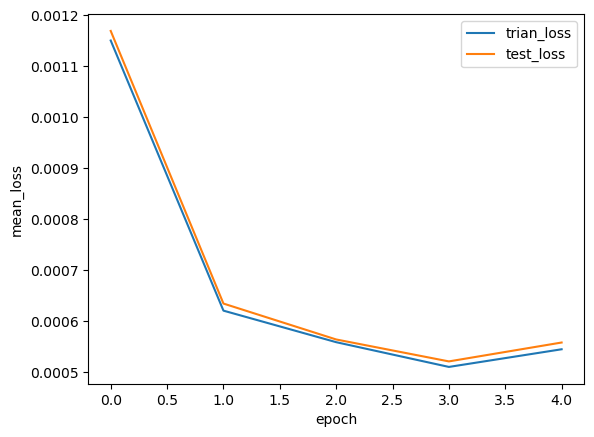

In [7]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,5)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.000416533605339905
test loss is 0.000539631635882777
Batch: 100,train loss is: 0.00029509391312849417
test loss is 0.00034515467262665833
Batch: 200,train loss is: 0.0002884921779783853
test loss is 0.0003914351748201286
Batch: 300,train loss is: 0.00035480139074867297
test loss is 0.00034635170000821237
Batch: 400,train loss is: 0.0003139895513359857
test loss is 0.00037880163476459257
Batch: 500,train loss is: 0.00035226626437377185
test loss is 0.0003202001837569722
Batch: 600,train loss is: 0.0002548638136054359
test loss is 0.00036513834817953494
Batch: 700,train loss is: 0.00045073571400820354
test loss is 0.00037254092209726577
Batch: 800,train loss is: 0.00033667481108098853
test loss is 0.00032598377237169537
Batch: 900,train loss is: 0.0004992500216306002
test loss is 0.0003572503749401134
Batch: 1000,train loss is: 0.0003134262775674148
test loss is 0.0003323792859690178
Batch: 1100,t

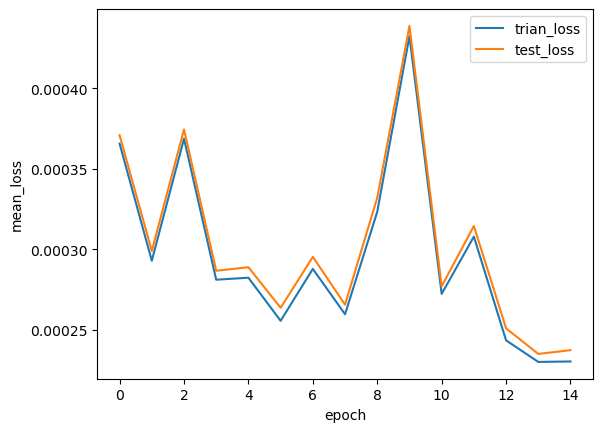

In [8]:
for param_group in optim_Adam.param_groups:
    param_group['lr'] = 0.00035

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,15)

In [9]:
torch.save(model.state_dict(),'../restruct_data_results/rflatBergomi_pointwise88_4-layer.pth')